# Lineage Tracking for Cells in the Mother Machine

In [1]:
from LineageTrack.lineage_tracker import LineageTrack
from LineageTrack.visualiser import Visualiser
from LineageTrack.measure_properties import generate_csv
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display, HTML
import pandas as pd
import ast

### comment out ###
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

In [2]:
exp_dir = "F:\\Cambridge\\MENG\\UROP 2022\\Data\\SyMBac\\T100-400_iter24_lysis005\\down_sample\\down_sample\\down_sample\\"
mask_dir = exp_dir + "masks\\"
channel_image_dir = exp_dir + "convolutions\\"
lineage_dir = exp_dir + "truth\\"
csv_save_dir = exp_dir + "csv\\"
result_save_dir = exp_dir + "results\\"
vis_save_dir = exp_dir + "track\\"

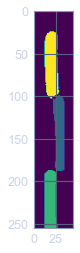

In [3]:
import tifffile

image = tifffile.imread(mask_dir + "\\synth_00020.tif")
# np.set_printoptions(threshold=100000)
# print(image)
plt.imshow(image)
plt.show()

# Measure cell properties from the images

In [4]:
generate_csv(mask_dir, channel_image_dir, dt=8, save_dir=csv_save_dir)

'saved to F:\\Cambridge\\MENG\\UROP 2022\\Data\\SyMBac\\T100-400_iter24_lysis005\\down_sample\\down_sample\\down_sample\\csv\\symbac_test.csv'

# Setup to start tracking

In [5]:
exp = LineageTrack.from_path(csv_save_dir)
print(exp)
display(exp.df.head(1))

Looking for data at these locations:
F:\Cambridge\MENG\UROP 2022\Data\SyMBac\T100-400_iter24_lysis005\down_sample\down_sample\down_sample\csv\symbac_test.csv
Finished loading the data
(120, 9)

                Read 1 files
                Channels: ['PC']
                Properties for each cell: ['PC_intensity_mean', 'area', 'centroid-0', 'centroid-1', 'label', 'major_axis_length', 'minor_axis_length', 'time_(mins)', 'trench_id']
            


,trench_id,time_(mins),label,area,major_axis_length,minor_axis_length,centroid-0,centroid-1,PC_intensity_mean
0,1,0,1,952,74.377838,17.015026,58.0,22.519958,16910.267578


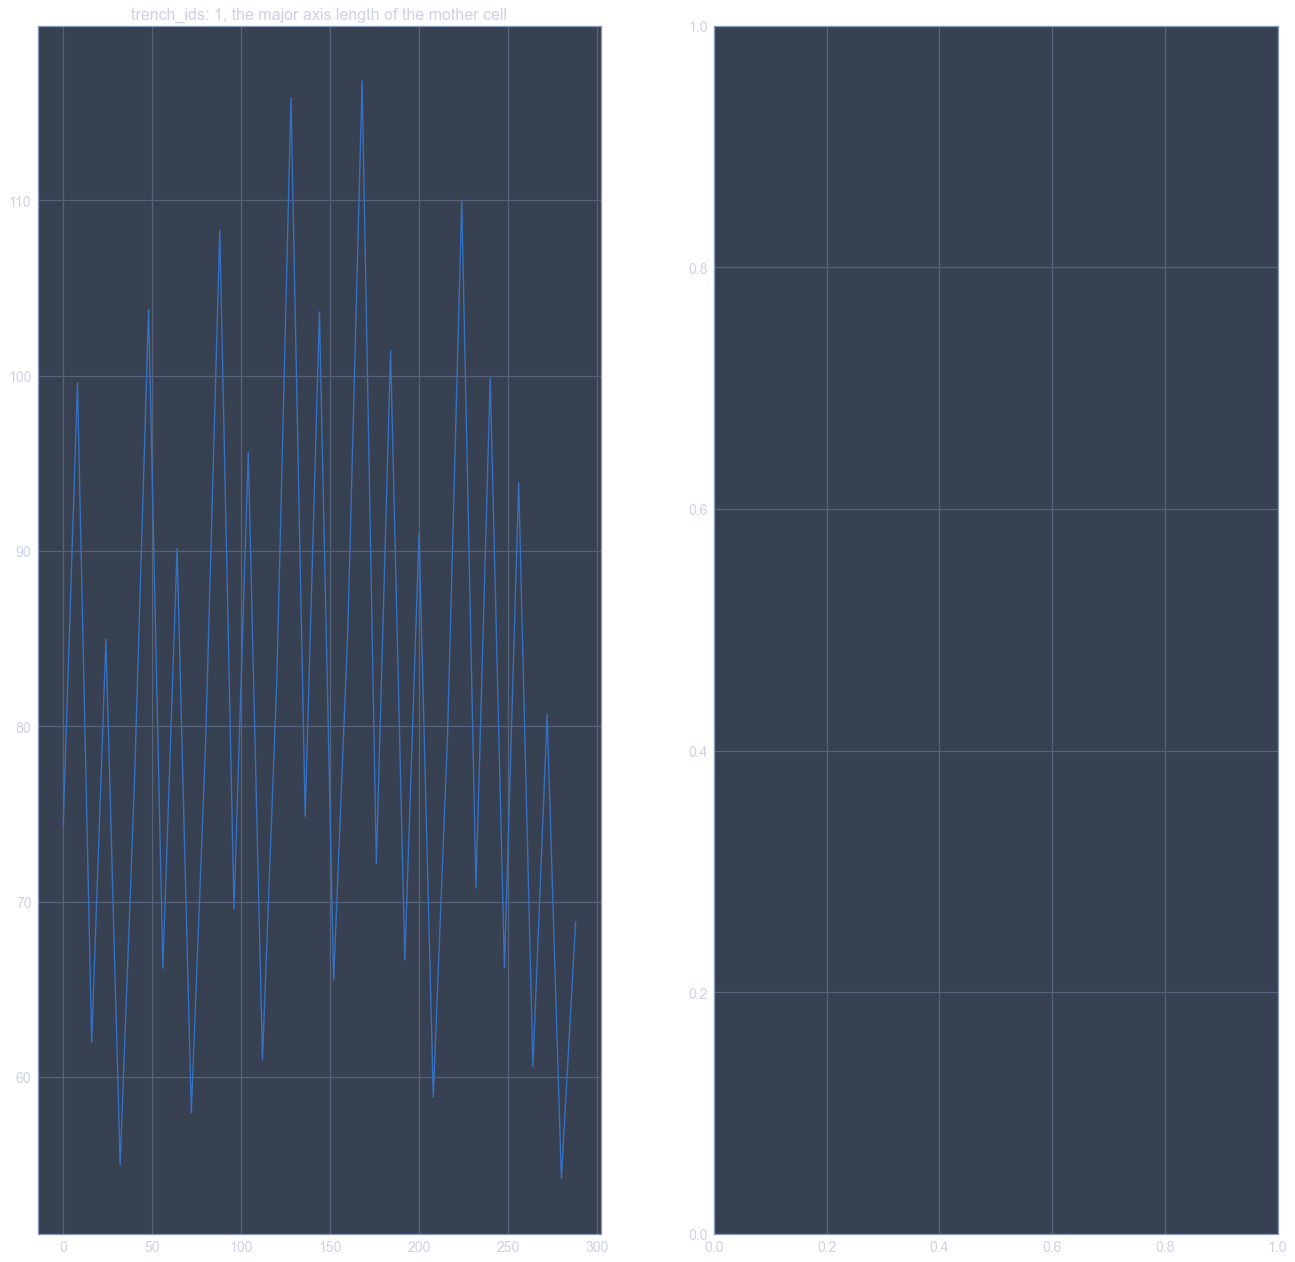

In [6]:
trench_list = [1]
m = exp.get_mother_cell_growth([1], plot=True)

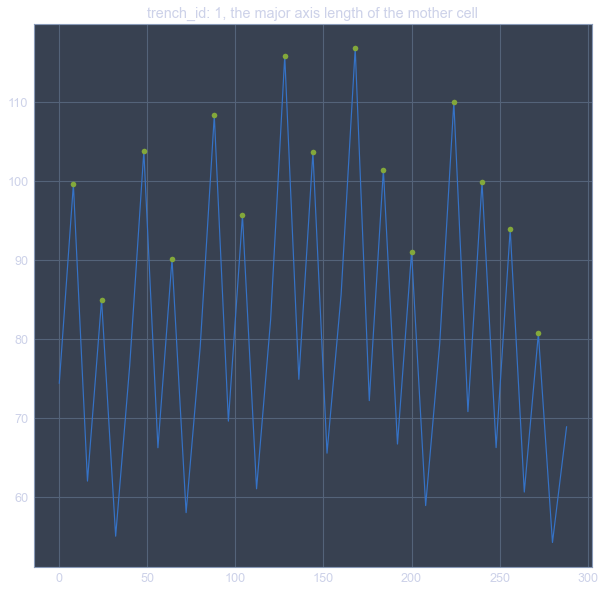

In [7]:
mcell1, idx1 = exp.find_division(1, threshold=None, distance=None)

In [8]:
e_phase_idx1 = idx1[:]
exp.collect_model_para(mcell1, e_phase_idx1, plot=False)

e:\cambridge\undergraduate-meng\urop\imageanalysisforcannibalism\repositories\mmlineagetracking\venv\lib\site-packages\scipy\stats\_stats_mstats_common.py:181: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
e:\cambridge\undergraduate-meng\urop\imageanalysisforcannibalism\repositories\mmlineagetracking\venv\lib\site-packages\scipy\stats\_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
e:\cambridge\undergraduate-meng\urop\imageanalysisforcannibalism\repositories\mmlineagetracking\venv\lib\site-packages\scipy\stats\_stats_mstats_common.py:198: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [9]:
exp.update_model_para(model="unif")


                    The average time interval for division is 18.857142857142858
                    The time constant for exponential growth is 18.355463293952546
                    The average division length is 99.69910837809245 with variance 104.2889533814498
                    


In [10]:
exp.growth_taus

[0.05995554424140004,
 0.05575531861464311,
 0.05442955069140698,
 0.04822543578378258,
 0.05403261427209771]

In [11]:
# track_df, lysis_df = exp.track_trench(trench=1, threshold=-1, max_dpf=3, show_details=False, ret_df=True)

In [12]:
exp.track_trenches(trenches=[1], threshold=-1, max_dpf=3, show_details=False, save_dir=result_save_dir)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Tracking over frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 31.47it/s]
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


'output saved at F:\\Cambridge\\MENG\\UROP 2022\\Data\\SyMBac\\T100-400_iter24_lysis005\\down_sample\\down_sample\\down_sample\\results\\track_TR_1.csv and F:\\Cambridge\\MENG\\UROP 2022\\Data\\SyMBac\\T100-400_iter24_lysis005\\down_sample\\down_sample\\down_sample\\results\\lysis_TR_1.csv.'

In [13]:
# display(HTML(track_df.to_html()))
# display(HTML(lysis_df.to_html()))

# Benchmark the lineage results by comparing to the true lineage

In [14]:
df_result = pd.read_csv(os.path.join(result_save_dir, "track_TR_1.csv"), converters={
            "label": ast.literal_eval,
            "parent_label": ast.literal_eval,
            "centroid": ast.literal_eval,
            "barcode": ast.literal_eval,
            "poles": ast.literal_eval
        })
df_true = pd.read_csv(os.path.join(lineage_dir, "true_lineage.csv"))

penalty = 0
for time in df_result.loc[:, "time_(mins)"]:
    parent_label_r = df_result.loc[df_result["time_(mins)"] == time, "parent_label"].copy()
    parent_label_r.reset_index(drop=True, inplace=True)
    parent_label_t = df_true.loc[df_true["time_(mins)"] == time, "parent_label"].copy()
    if time != df_result.at[0, "time_(mins)"]:
        for label1, label2 in zip(parent_label_r[0], list(parent_label_t)):
            if label1:
                if int(label1) != int(label2):
                    print("wrong")
                    print(time)
                    print(parent_label_r[0])
                    print(list(parent_label_t))
                    penalty += 1
                
            else:
                print(time)
                print(parent_label_r[0])
                print(list(parent_label_t))
print("penalty score: {}".format(penalty))

penalty score: 0


# Visualisation of the results

In [15]:
# vis = Visualiser("000", track_df, lysis_df)
vis = Visualiser.from_path("000", 
                           os.path.join(result_save_dir, "track_TR_1.csv"),  
                           os.path.join(result_save_dir, "lysis_TR_1.csv"))

template_mask = ['synth_0']

In [16]:
vis.label_images(channel_image_dir, mode="landscape-line", save_dir=vis_save_dir, template=template_mask, template_mode="SyMBac")

files = [vis_save_dir + f for f in os.listdir(vis_save_dir)if os.path.isfile(os.path.join(vis_save_dir, f))]

saved as F:\Cambridge\MENG\UROP 2022\Data\SyMBac\T100-400_iter24_lysis005\down_sample\down_sample\down_sample\track\\synth_0.tif


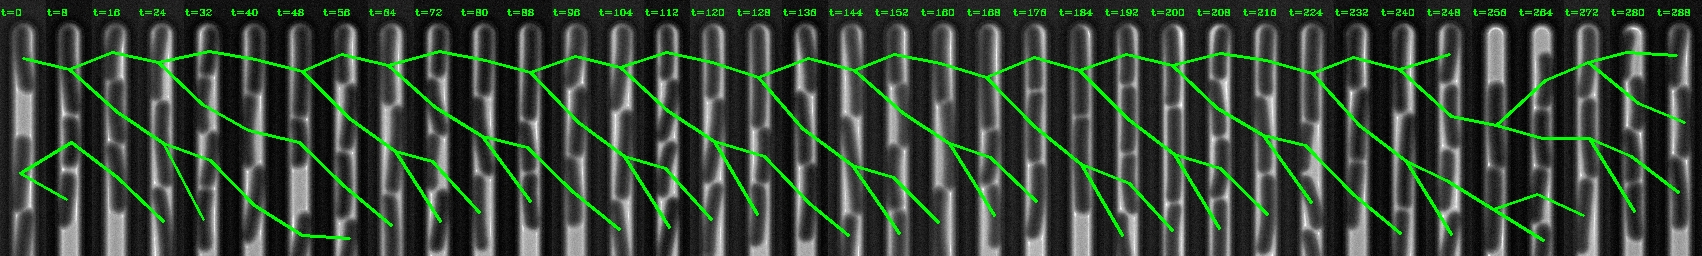

In [17]:
import cv2 as cv

read = cv.imread(files[0])
outfile = files[0].split('.')[0] + '.jpg'
cv.imwrite(outfile, read, [int(cv.IMWRITE_JPEG_QUALITY), 200])
display(Image(outfile, unconfined=True))
